In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from operator import add, sub

np.random.seed(2017)

In [3]:
#from pyspark import SparkContext
#sc.stop()

#from pyspark.sql import SparkSession

#sc = SparkSession.builder \
#    .master("local") \
#    .appName("Python Spark SQL") \
#    .getOrCreate()

In [2]:
from pyspark import SparkContext

sc.stop()

SparkContext.setSystemProperty('spark.executor.memory', '2g')
SparkContext.setSystemProperty('spark.executor.cores', '4')

sc = SparkContext("local", "App Name")

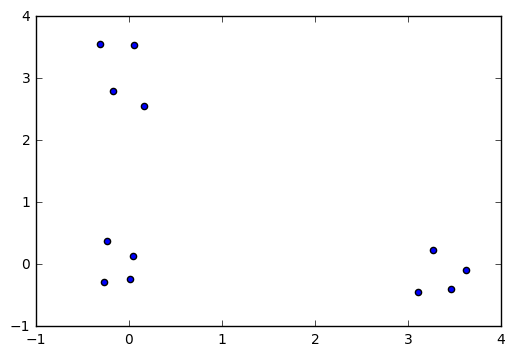

In [5]:
# Temporary cell. To be deleted later

N = 4

x_1 = np.random.multivariate_normal(mean = [0,0], cov = [[0.1,0],[0,0.1]], size = N)
x_2 = np.random.multivariate_normal(mean = [3,0], cov = [[0.3,-0.1],[-0.1,0.2]], size = N)
x_3 = np.random.multivariate_normal(mean = [0,3], cov = [[0.2,0],[0,0.2]], size = N)
N = 3 * N
X = np.concatenate((x_1, x_2, x_3))

plt.scatter(X[:,0], X[:,1])
plt.show()

pd.DataFrame(X).to_csv("gaussian_data.txt", sep="\t", header=None, index=True)

In [6]:
#mat1 = sc.textFile("gaussian_data.txt") 
#test = sqlContext.createDataFrame(mat1)
from pyspark.sql.types import *
lines = sc.textFile("gaussian_data.csv")
parts = lines.map(lambda l: l.split(","))

# Each line is converted to a tuple.
data = parts.map(lambda p: (p[0], p[1], p[2]))

# The schema is encoded in a string.
schemaString = "x1 x2 x3"

fields = [StructField(field_name, FloatType(), True) for field_name in schemaString.split()]
schema = StructType(fields)

# Apply the schema to the RDD.
spark_data = spark.createDataFrame(data, schema)

In [9]:
spark_data.

<bound method DataFrame.count of DataFrame[x1: float, x2: float, x3: float]>

In [36]:
# As we can't rely on data order in a Map/Reduce paradigm, we add the values' coordinates in each row.
def addCoordinates(row):
    """
    This function adds the matrix coordinates to each value.

    Parameters
    ----------
    row: row of Spark RDD
            This is one row of the current Spark RDD we're parsing.

    Returns
    -------
    result: list
            This is the preprocessed row, with coordinates added.
    """
    
    values = row.split("\t")
    index = int(values[0])
    values = [float(_) for _ in values[1:]]
    result = [[index, j, v] for j, v in enumerate(values)]
    
    return result

def computeSimilarity(row):
    """
    This function adds the matrix coordinates to each value.

    Parameters
    ----------
    row: row of Spark RDD
            This is one row of the current Spark RDD we're parsing.

    Returns
    -------
    similarity: tuple
            This is computed similarity, with matrix coordinates added.
    """
    
    ((i, v1), (j, v2)) = row
    similarity = i, j, -1 * ((v1 - v2) ** 2)
    
    return similarity

def GenerateSimilarityMatrix():
    """
    This method generates the similarity matrix for all the points given to the mapper.

    Parameters
    ----------
    None

    Returns
    -------
    S: Spark RDD
            This is the computed similarity matrix in the Spark RDD format.
    """
    
    # Open the text file and add coordinates to each row
    #mat1 = sc.textFile("gaussian_data.txt")
    mat1 = spark_data
    new_mat1 = mat1.
    #flatMap(addCoordinates)
    
    # Generate a RDD for x coordinates and one for y coordinates
    new_mat_x = new_mat1.filter(lambda x: x[1] == 0).map(lambda row: (row[0], row[2]))
    new_mat_y = new_mat1.filter(lambda x: x[1] == 1).map(lambda row: (row[0], row[2]))
    
    # Compute the cartesian product for x and y
    mat_cartesian_x = new_mat_x.cartesian(new_mat_x)
    mat_cartesian_y = new_mat_y.cartesian(new_mat_y)
    
    # Compute the similarity for x and y
    sim_x = mat_cartesian_x.map(computeSimilarity)
    sim_y = mat_cartesian_y.map(computeSimilarity)
    
    # Concatenate both x- and y-RDD and sum them by identical keys. Remove cells that equal zero
    sim = sc.union([sim_x, sim_y])
    final = sim.map(lambda row: ((row[0], row[1]), row[2])).reduceByKey(add).filter(lambda x: x[1] != 0)
    
    # Compute the matrix's diagonal
    median = np.median(final.map(lambda row: row[1]).collect())
    diagonal = sc.sparkContext.parallelize(range(mat1.count())).map(lambda x: ((x, x), median))
    
    # Generate the final matrix
    S = sc.sparkContext.union([final, diagonal])
    
    return S

S = GenerateSimilarityMatrix()

AttributeError: 'DataFrame' object has no attribute 'flatMap'

In [6]:
def computeR(A, R, S, N):
    # Compute the sum of A and S
    sumA_S = sc.sparkContext.union([A, S]).reduceByKey(add)

    # Remove all rows where i == k and compute the maximum
    tmp = sc.sparkContext.parallelize(range(N)).cartesian(sumA_S)
    tmp = tmp.map(lambda row: (row[0], (row[1][0][1], (row[1][0][0], row[1][1])))).filter(lambda row: row[1][0] != row[0])
    maximum = tmp.map(lambda row: ((row[1][1][0], row[0]), row[1][1][1])).reduceByKey(max)

    # Compute r
    r = sc.sparkContext.union([S, maximum]).reduceByKey(sub)

    # Compute R
    R = R.join(r).map(lambda row: (row[0], (1 - lambdaValue) * row[1][1] + lambdaValue * row[1][0]))
    
    return R

In [7]:
def computeA(A, R, N):
    # Remove all rows where i == k and compute the maximum
    tmp = R.filter(lambda row: row[0][0] != row[0][1])
    tmp = sc.sparkContext.parallelize(range(N)).cartesian(tmp).filter(lambda row: row[0] != row[1][0][0] and row[0] != row[1][0][1])
    maximum = tmp.map(lambda row: (row[1][0], max(0, row[1][1]))).reduceByKey(add)

    # Add R[k, k]
    tmp = maximum.map(lambda row: ((row[0][1], row[0][1]), row)).join(R.filter(lambda row: row[0][0] == row[0][1]))
    a = tmp.map(lambda row: (row[1][0][0], min(0, row[1][0][1] + row[1][1])))

    # Compute the value of a when i == k
    tmp = R.filter(lambda row: row[0][0] == row[0][1])
    tmp = sc.sparkContext.parallelize(range(N)).cartesian(tmp).filter(lambda row: row[0] != row[1][0][1])
    maximum = tmp.map(lambda row: (row[1][0], max(0, row[1][1]))).reduceByKey(add)

    # Join both RDDs
    a = sc.sparkContext.union([a, maximum])

    # Compute A
    A = A.join(a).map(lambda row: (row[0], (1 - lambdaValue) * row[1][1] + lambdaValue * row[1][0]))
    
    return A

In [8]:
# Create A and R matrices
A = sc.sparkContext.parallelize(range(N)).flatMap(lambda x: [((x, y), 0) for y in range(N)])
R = sc.sparkContext.parallelize(range(N)).flatMap(lambda x: [((x, y), 0) for y in range(N)])
lambdaValue = 0.5

In [9]:
iterations = 10
for iter in range(iterations):
    if iter % 2 == 0:
        print(iter, "iterations done")
    # Update r(i, k) given a(i, k)
    R = computeR(A, R, S, N)
    
    # Update a(i, k) given r(i, k)
    A = computeA(A, R, N)

0 iterations done
2 iterations done


Py4JJavaError: An error occurred while calling o916.partitions.
: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.lang.Integer.valueOf(Unknown Source)
	at scala.runtime.BoxesRunTime.boxToInteger(BoxesRunTime.java:65)
	at scala.collection.IndexedSeqOptimized$class.zipWithIndex(IndexedSeqOptimized.scala:103)
	at scala.collection.mutable.ArrayOps$ofRef.zipWithIndex(ArrayOps.scala:186)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:249)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:246)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:246)
	at org.apache.spark.api.java.JavaRDDLike$class.partitions(JavaRDDLike.scala:60)
	at org.apache.spark.api.java.AbstractJavaRDDLike.partitions(JavaRDDLike.scala:45)
	at sun.reflect.GeneratedMethodAccessor41.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Unknown Source)
